<a href="https://colab.research.google.com/github/Kim-matthew-0422/deep-learning-compputer-vision-thorax-cancer-identification/blob/main/thorax%20computer%20imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Jan 25 04:22:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-25 04:22:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-25 04:22:48 (99.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [4]:
!mkdir ~/.kaggle 

cp: cannot stat 'kaggle.json': No such file or directory


In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"etkim422","key":"ba5083a771515c1999a723e17e69eb58"}'}

In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

100% 119M/119M [00:06<00:00, 20.0MB/s]
100% 119M/119M [00:06<00:00, 18.2MB/s]


In [8]:
unzip_data("chest-ctscan-images.zip")

In [9]:
train_dir = 'Data/train/'
test_dir = 'Data/test/'

In [10]:
walk_through_dir("Data")

There are 3 directories and 0 images in 'Data'.
There are 4 directories and 0 images in 'Data/train'.
There are 0 directories and 155 images in 'Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'.
There are 0 directories and 195 images in 'Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'.
There are 0 directories and 115 images in 'Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'.
There are 0 directories and 148 images in 'Data/train/normal'.
There are 4 directories and 0 images in 'Data/valid'.
There are 0 directories and 15 images in 'Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'.
There are 0 directories and 23 images in 'Data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'.
There are 0 directories and 21 images in 'Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'.
There are 0 directories and 13 images in 'Data/valid/normal'.
There are 4 directories and 0 images in 'Data/test'.
There are 0 directories and 51 images in 'Data/test/large

In [11]:
image_shape = (305,430,3)
N_CLASSES = 4
BATCH_SIZE = 32
train_path = "Data/train"
valid_path = "Data/valid"
test_path = "Data/test"
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


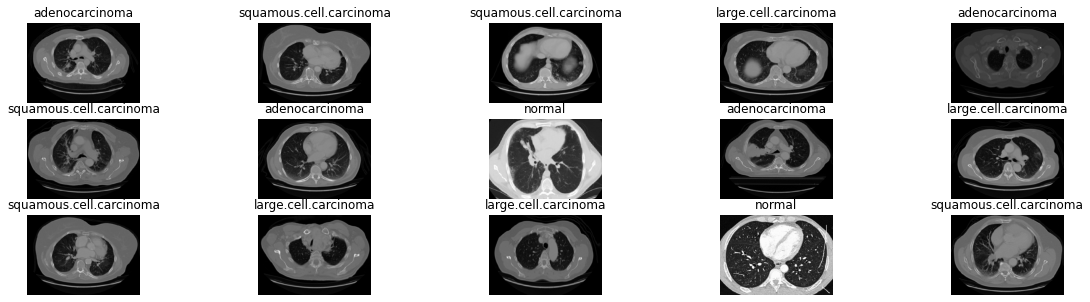

In [12]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import pandas as pd
class_names=list(test_generator.class_indices.keys())
print(class_names)

fig = plt.figure(figsize=(20,5))

image_batch,label_batch = test_generator[1]
for i in range(15):
    ax = fig.add_subplot(3,5,i+1,xticks = [], yticks = [])
    ax.imshow(image_batch[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label_batch[i])])

In [13]:
import tensorflow as tf

from keras import optimizers
from keras.utils import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.applications import ResNet50, DenseNet201
from keras.applications import resnet, densenet
first_model = Sequential([
  Conv2D(8, 2, padding='same', activation='relu', input_shape = image_shape),
  MaxPooling2D(2),
  Conv2D(16, 2, padding='same', activation='relu'),
  MaxPooling2D(2),

  Dropout(0.4),
  Flatten(),
  Dense(256, activation='relu'),
  Dropout(0.4),
  Dense(4, activation='softmax')
])
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 305, 430, 8)       104       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 152, 215, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 152, 215, 16)      528       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 76, 107, 16)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 76, 107, 16)       0         
                                                                 
 flatten (Flatten)           (None, 130112)            0

In [14]:
checkpointer = ModelCheckpoint('chestmodel.hdf5',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 10)
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-5)

first_model.compile(loss= 'categorical_crossentropy', optimizer= optimizer, metrics=['acc'])
history = first_model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 80,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/80
20/20 [==============================] - ETA: 0s - loss: 1.3185 - acc: 0.3507
Epoch 1: val_loss improved from inf to 1.32540, saving model to chestmodel.hdf5
20/20 [==============================] - 14s 306ms/step - loss: 1.3185 - acc: 0.3507 - val_loss: 1.3254 - val_acc: 0.3750
Epoch 2/80
20/20 [==============================] - ETA: 0s - loss: 1.2013 - acc: 0.4502
Epoch 2: val_loss improved from 1.32540 to 1.27312, saving model to chestmodel.hdf5
20/20 [==============================] - 5s 258ms/step - loss: 1.2013 - acc: 0.4502 - val_loss: 1.2731 - val_acc: 0.4028
Epoch 3/80
20/20 [==============================] - ETA: 0s - loss: 1.1299 - acc: 0.4861
Epoch 3: val_loss improved from 1.27312 to 1.25380, saving model to chestmodel.hdf5
20/20 [==============================] - 5s 272ms/step - loss: 1.1299 - acc: 0.4861 - val_loss: 1.2538 - val_acc: 0.4028
Epoch 4/80
20/20 [==============================] - ETA: 0s - loss: 1.0788 - acc: 0.5269
Epoch 4: val_loss improved from 

In [15]:
result = first_model.evaluate(test_generator)

10/10 [==============================] - 4s 422ms/step - loss: 1.2530 - acc: 0.5714


In [16]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [17]:
dense_model = DenseNet201(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))

# make all layers except conv5 layers not trainable
for layer in dense_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False

74836368/74836368 [==============================] - 4s 0us/step


In [18]:
densenet_model = Sequential()
densenet_model.add(dense_model)
densenet_model.add(Flatten())
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(N_CLASSES, activation='softmax'))
densenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 flatten_1 (Flatten)         (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 4)                 7684      
                                                                 
Total params: 18,337,348
Trainable params: 6,990,084
Non-trainable params: 11,347,264
_________________________________________________________________


In [19]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
densenet_model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

checkpointer = ModelCheckpoint(filepath='./chestmodel-DenseNet201.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [20]:
history_dense = densenet_model.fit(train_generator,
                                steps_per_epoch = 20,
                                epochs = 80,
                                verbose = 1,
                                validation_data = valid_generator,
                                callbacks = [checkpointer, early_stopping])

Epoch 1/80
20/20 [==============================] - ETA: 0s - loss: 1.3189 - acc: 0.4029
Epoch 1: val_loss improved from inf to 1.36090, saving model to ./chestmodel-DenseNet201.hdf5
20/20 [==============================] - 47s 1s/step - loss: 1.3189 - acc: 0.4029 - val_loss: 1.3609 - val_acc: 0.3194
Epoch 2/80
20/20 [==============================] - ETA: 0s - loss: 0.7639 - acc: 0.7276
Epoch 2: val_loss improved from 1.36090 to 1.27050, saving model to ./chestmodel-DenseNet201.hdf5
20/20 [==============================] - 16s 786ms/step - loss: 0.7639 - acc: 0.7276 - val_loss: 1.2705 - val_acc: 0.4722
Epoch 3/80
20/20 [==============================] - ETA: 0s - loss: 0.5523 - acc: 0.8303
Epoch 3: val_loss improved from 1.27050 to 1.20172, saving model to ./chestmodel-DenseNet201.hdf5
20/20 [==============================] - 16s 794ms/step - loss: 0.5523 - acc: 0.8303 - val_loss: 1.2017 - val_acc: 0.4722
Epoch 4/80
20/20 [==============================] - ETA: 0s - loss: 0.4059 - acc

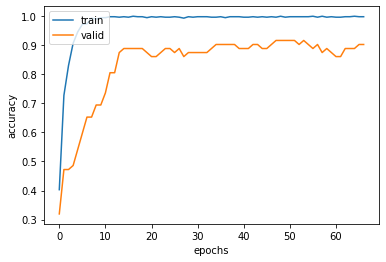

In [21]:
plt.plot(history_dense.history['acc'], label = 'train')
plt.plot(history_dense.history['val_acc'], label = 'valid')

plt.legend(loc = 'upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [22]:
dns_result = densenet_model.evaluate(test_generator)

10/10 [==============================] - 13s 1s/step - loss: 0.3748 - acc: 0.8921


In [25]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype = 'float32')
train_generator = train_datagen.flow_from_directory(train_path,
                                                    batch_size = BATCH_SIZE,
                                                    target_size = (460,460),
                                                    class_mode = 'categorical')
valid_datagen = ImageDataGenerator(dtype = 'float32')
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                    batch_size = BATCH_SIZE,
                                                    target_size = (460, 460),
                                                    class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype = 'float32')
test_generator = test_datagen.flow_from_directory(test_path,
                                                  batch_size = BATCH_SIZE,
                                                  target_size =(460,460),
                                                  class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [26]:
res_model = ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet', input_shape= (image_shape))

for layer in res_model.layers:
  if 'conv5' not in layer.name:
    layer.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


In [27]:
resnet_model = Sequential()
resnet_model.add(res_model)
resnet_model.add(Dropout(0.4))
resnet_model.add(Flatten())
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.4))
resnet_model.add(Dense(N_CLASSES, activation='softmax'))
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 4)                 8196      
                                                      

In [28]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-5)
resnet_model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [29]:
checkpointer = ModelCheckpoint(filepath='./finalmodel-ResNet50.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=20)

In [30]:
history_res = resnet_model.fit(train_generator,
                            steps_per_epoch = 20,
                            epochs = 120,
                            verbose = 1,
                            validation_data = valid_generator,
                            callbacks = [checkpointer, early_stopping])

Epoch 1/120
20/20 [==============================] - ETA: 0s - loss: 1.9662 - acc: 0.3328
Epoch 1: val_loss improved from inf to 1.44189, saving model to ./finalmodel-ResNet50.hdf5
20/20 [==============================] - 23s 860ms/step - loss: 1.9662 - acc: 0.3328 - val_loss: 1.4419 - val_acc: 0.4444
Epoch 2/120
20/20 [==============================] - ETA: 0s - loss: 1.4999 - acc: 0.4796
Epoch 2: val_loss improved from 1.44189 to 1.23316, saving model to ./finalmodel-ResNet50.hdf5
20/20 [==============================] - 14s 675ms/step - loss: 1.4999 - acc: 0.4796 - val_loss: 1.2332 - val_acc: 0.4861
Epoch 3/120
20/20 [==============================] - ETA: 0s - loss: 1.1351 - acc: 0.5775
Epoch 3: val_loss improved from 1.23316 to 1.09851, saving model to ./finalmodel-ResNet50.hdf5
20/20 [==============================] - 13s 655ms/step - loss: 1.1351 - acc: 0.5775 - val_loss: 1.0985 - val_acc: 0.5139
Epoch 4/120
20/20 [==============================] - ETA: 0s - loss: 0.9526 - acc: 

In [31]:
result = resnet_model.evaluate(test_generator)

10/10 [==============================] - 7s 661ms/step - loss: 0.4106 - acc: 0.8508


In [32]:
from keras.models import load_model
resnet50_model = load_model('finalmodel-ResNet50.hdf5')

In [36]:
paths = ["Data/test/adenocarcinoma/", "Data/test/large.cell.carcinoma/", "Data/test/normal/", "Data/test/squamous.cell.carcinoma/"]
results = {"adeno":{0:0, 1:0, 2:0, 3:0},
            "large":{0:0, 1:0, 2:0, 3:0},
            "normal":{0:0, 1:0, 2:0, 3:0},
            "squamous":{0:0, 1:0, 2:0, 3:0}}

for path, key in zip(paths, results.keys()):
    
    for file in os.listdir(path):
        img = tf.keras.utils.load_img(
            (path + file), target_size=(460, 460)
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        prediction = resnet50_model.predict(img_array, verbose=0)
        results[key][np.argmax(prediction)] = results.get(key).get(np.argmax(prediction),0) + 1

results
df = pd.DataFrame(results)

print("Overall accuracy is : {:.2f}%\n".format((df["adeno"][0] + df["large"][1] + df["normal"][2] + df["squamous"][3]) / 315 * 100))

print("Adeno cancer detection accuracy is : {:.2f}%".format(df["adeno"][0] / df["adeno"].sum() * 100))
print("Large cell cancer detection accuracy is : {:.2f}%".format(df["large"][1] / df["large"].sum() * 100))
print("Normal chest detection accuracy is : {:.2f}%".format(df["normal"][2] / df["normal"].sum() * 100))
print("Squamous cell cancer detection accuracy is : {:.2f}%".format(df["squamous"][3] / df["squamous"].sum() * 100))

print("\nConfusion Matrix :")
df.transpose()


Overall accuracy is : 88.25%

Adeno cancer detection accuracy is : 83.33%
Large cell cancer detection accuracy is : 84.31%
Normal chest detection accuracy is : 98.15%
Squamous cell cancer detection accuracy is : 91.11%

Confusion Matrix :


,0,1,2,3
adeno,100,11,0,9
large,7,43,0,1
normal,0,1,53,0
squamous,8,0,0,82


In [38]:
img_path = "Data/test/squamous.cell.carcinoma/000111.png"

class_names=list(test_generator.class_indices.keys())

img = tf.keras.utils.load_img(img_path, target_size=(460, 460))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

prediction = resnet50_model.predict(img_array)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(prediction)], 100 * np.max(prediction))
)

1/1 [==============================] - 0s 21ms/step
This image most likely belongs to squamous.cell.carcinoma with a 86.65 percent confidence.
